In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Model
from keras.layers import *
from keras.callbacks import *

from keras.regularizers import l2
from keras.optimizers import *
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Q3
Function defenitions

In [0]:
def month_extractor(row):
  return row['date'].split('.')[1]

def year_extractor(row):
  return row['date'].split('.')[2]

def city_extractor(row):
  return row['shop_name'].split(' ')[0]

def plot_history(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df

def set_callbacks(description='run1',patience=7,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint('best_model_weights_{}.h5'.format(description),save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=3)   
    tb = TensorBoard(log_dir='{}{}'.format(tb_base_logdir,description))
    cb = [cp,es,tb,rlop]
    return cb

Load the data

In [0]:
folder='/content/drive/My Drive/DL HW2/' 

shops = pd.read_csv(folder + 'shops.csv', engine='python')
items = pd.read_csv(folder + 'items.csv', engine='python')
item_categories = pd.read_csv(folder + 'item_categories.csv', engine='python')
train = pd.read_csv(folder + 'sales_train.csv', engine='python')
test = pd.read_csv(folder + 'test.csv', engine='python')

Let's visualize item prices and items daily sales to spot outliers.

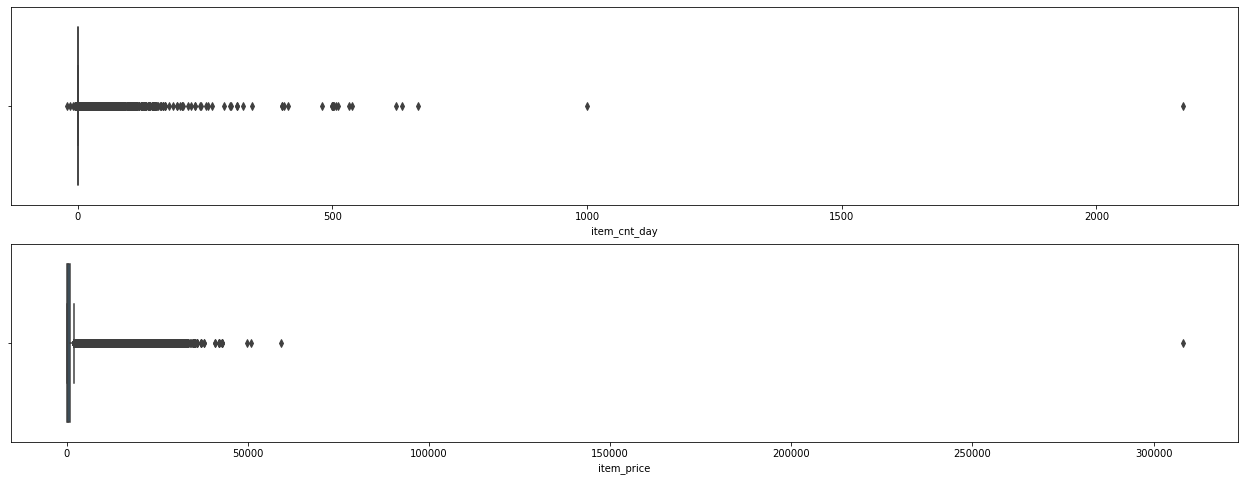

In [0]:
plt.figure(figsize=(22,8))
plt.subplot(2, 1, 1)
sns.boxplot(x=train['item_cnt_day'])
plt.subplot(2, 1, 2)
sns.boxplot(x=train['item_price'])


We can clearly see we have a couple of outliers in the top range, and for the daily sale count we even have a few examples of negative numbers, which might be a an error in the data, or represent returned items.

Either way, we will get rid of the outliers.

In [6]:
print(train.shape)
train = train.query('item_cnt_day >= 0 and item_cnt_day <= 1500 and item_price < 100000')
print(train.shape)


(2935849, 6)
(2928491, 6)


# Feature engineering

In [7]:
# From the date column we can extract month, and year. 
# As we predict selling amount for an entire month, extracting the days is irrelevant.
# We can also extract the city name in which the store is located from the shop name.
train['month'] = train.apply(lambda row: month_extractor(row), axis=1)
train['year'] = train.apply(lambda row: year_extractor(row), axis=1)
shops['city'] = shops.apply(lambda row: city_extractor(row), axis=1)


# We have no use for the names themselves, so we will encode them.
le_city = LabelEncoder()
shops['city'] = le_city.fit_transform(shops['city'])

le_month = LabelEncoder()
train['month'] = le_month.fit_transform(train['month'])

print(train.head())
print(test.head())

         date  date_block_num  shop_id  ...  item_cnt_day  month  year
0  02.01.2013               0       59  ...           1.0      0  2013
1  03.01.2013               0       25  ...           1.0      0  2013
3  06.01.2013               0       25  ...           1.0      0  2013
4  15.01.2013               0       25  ...           1.0      0  2013
5  10.01.2013               0       25  ...           1.0      0  2013

[5 rows x 8 columns]
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


Calculate the target item_cnt_month

In [8]:
train = train.groupby(['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day': ['sum'], 'month': ['first'], 'year': ['first']})


train.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'month', 'year']
train.item_cnt_month = train.item_cnt_month.clip(0, 20)

print(train.columns.values)
print(train.head(20))

['date_block_num' 'shop_id' 'item_id' 'item_cnt_month' 'month' 'year']
    date_block_num  shop_id  item_id  item_cnt_month  month  year
0                0        0       32             6.0      0  2013
1                0        0       33             3.0      0  2013
2                0        0       35             1.0      0  2013
3                0        0       43             1.0      0  2013
4                0        0       51             2.0      0  2013
5                0        0       61             1.0      0  2013
6                0        0       75             1.0      0  2013
7                0        0       88             1.0      0  2013
8                0        0       95             1.0      0  2013
9                0        0       96             1.0      0  2013
10               0        0       98            20.0      0  2013
11               0        0      111             1.0      0  2013
12               0        0      149             3.0      0  2013
13   

We would like to add extracted data to the test set as well, so we have to fill in missig data before we can concat the test and training sets.

We will be able to tell the data apart later on using the 'date_block_num' column, in which the test set has a value of 34.

In [0]:
test['date_block_num'] = 34
test['month'] = 10
test['year'] = 2015

In [36]:
print(train.head())
print(test.head())

   date_block_num  shop_id  item_id  item_cnt_month  month  year
0               0        0       32             6.0      0  2013
1               0        0       33             3.0      0  2013
2               0        0       35             1.0      0  2013
3               0        0       43             1.0      0  2013
4               0        0       51             2.0      0  2013
   ID  shop_id  item_id  date_block_num  year  month
0   0        5     5037              34  2015     10
1   1        5     5320              34  2015     10
2   2        5     5233              34  2015     10
3   3        5     5232              34  2015     10
4   4        5     5268              34  2015     10


Finally concatenate the dataframes.

In [10]:
sales = pd.concat([train, test.drop(['ID'], axis=1)]).fillna(0)

print(sales)

        date_block_num  shop_id  item_id  item_cnt_month  month  year
0                    0        0       32             6.0      0  2013
1                    0        0       33             3.0      0  2013
2                    0        0       35             1.0      0  2013
3                    0        0       43             1.0      0  2013
4                    0        0       51             2.0      0  2013
...                ...      ...      ...             ...    ...   ...
214195              34       45    18454             0.0     10  2015
214196              34       45    16188             0.0     10  2015
214197              34       45    15757             0.0     10  2015
214198              34       45    19648             0.0     10  2015
214199              34       45      969             0.0     10  2015

[1822425 rows x 6 columns]


We can make use of the item category and the shop city we extracted earlier. Let's join them into the dataframe.

In [11]:
sales = pd.merge(sales, items[["item_id", "item_category_id"]], on='item_id', how='left').fillna(-1)
sales = pd.merge(sales, shops[["shop_id", "city"]], on='shop_id', how='left').fillna('')

print(sales.head())

   date_block_num  shop_id  item_id  ...  year  item_category_id city
0               0        0       32  ...  2013                40    0
1               0        0       33  ...  2013                37    0
2               0        0       35  ...  2013                40    0
3               0        0       43  ...  2013                40    0
4               0        0       51  ...  2013                57    0

[5 rows x 8 columns]


Add previous item_cnt_month values, for 1,2,3,6 and 12 months earlier.

In [0]:
sales = lag_feature(sales, [1,2,3,6,12], 'item_cnt_month')

In [13]:
#We will engineer features using only the train set, as the test set has no data 
#and is filles with 0's

train = sales.query('date_block_num < 34')

#Add shop-month avg sales
group = train.groupby(['shop_id', 'month',], as_index=False).agg({'item_cnt_month': np.average})
group = group.rename(columns={'item_cnt_month': 'shop_month_avg'})
sales = pd.merge(sales, group, how='left', on=['shop_id', 'month'])

#Add item-month avg sales
group = train.groupby(['item_id', 'month',], as_index=False).agg({'item_cnt_month': np.average})
group = group.rename(columns={'item_cnt_month': 'item_month_avg'})
sales = pd.merge(sales, group, how='left', on=['item_id', 'month'])

#Add city-cat-month avg sales
group = train.groupby(['item_category_id', 'month', 'city'], as_index=False).agg({'item_cnt_month': np.average})
group = group.rename(columns={'item_cnt_month': 'city_cat_month_avg'})
sales = pd.merge(sales, group, how='left', on=['item_category_id', 'month', 'city'])

#Add shop-cat-month avg sales
group = train.groupby(['item_category_id', 'month', 'shop_id'], as_index=False).agg({'item_cnt_month': np.average})
group = group.rename(columns={'item_cnt_month': 'shop-cat-month'})
sales = pd.merge(sales, group, how='left', on=['item_category_id', 'month', 'shop_id'])

sales.columns.values
sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,month,year,item_category_id,city,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_month_avg,item_month_avg,city_cat_month_avg,shop-cat-month
0,0,0,32,6.0,0,2013,40,0,0.0,0.0,0.0,0.0,0.0,2.268763,4.054945,1.863329,2.126050
1,0,0,33,3.0,0,2013,37,0,0.0,0.0,0.0,0.0,0.0,2.268763,1.876923,1.346801,1.440191
2,0,0,35,1.0,0,2013,40,0,0.0,0.0,0.0,0.0,0.0,2.268763,3.250000,1.863329,2.126050
3,0,0,43,1.0,0,2013,40,0,0.0,0.0,0.0,0.0,0.0,2.268763,1.000000,1.863329,2.126050
4,0,0,51,2.0,0,2013,57,0,0.0,0.0,0.0,0.0,0.0,2.268763,1.350000,1.176471,1.176471


Downcast the values, to take up less memory and expedite the learning process.

In [14]:
sales.year = sales.year.astype(np.int16)

float_cols = [c for c in sales if sales[c].dtype == "float64"]
int_cols = [c for c in sales if sales[c].dtype == "int64"]

sales[float_cols] = sales[float_cols].astype(np.float32)
sales[int_cols] = sales[int_cols].astype(np.int32)

sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822425 entries, 0 to 1822424
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int32  
 1   shop_id                int32  
 2   item_id                int32  
 3   item_cnt_month         float32
 4   month                  int32  
 5   year                   int16  
 6   item_category_id       int32  
 7   city                   int32  
 8   item_cnt_month_lag_1   float32
 9   item_cnt_month_lag_2   float32
 10  item_cnt_month_lag_3   float32
 11  item_cnt_month_lag_6   float32
 12  item_cnt_month_lag_12  float32
 13  shop_month_avg         float32
 14  item_month_avg         float32
 15  city_cat_month_avg     float32
 16  shop-cat-month         float32
dtypes: float32(10), int16(1), int32(6)
memory usage: 128.6 MB


Split test and train data, and create a validation set.

In [15]:
train = sales.query('date_block_num < 34')
test = sales.query('date_block_num == 34')
X = train.drop(['item_cnt_month'], axis=1)
y = train['item_cnt_month']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
del X
del y
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(1286580, 16)
(1286580,)
(321645, 16)
(321645,)


Lets train a ML model to get a performance benchmark.

In [20]:
reg = xgb.XGBRegressor(n_estimators=100, max_depth=7, objective='reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:2.78394	validation_1-rmse:2.79837
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.59938	validation_1-rmse:2.61388
[2]	validation_0-rmse:2.43832	validation_1-rmse:2.45255
[3]	validation_0-rmse:2.29722	validation_1-rmse:2.31115
[4]	validation_0-rmse:2.17519	validation_1-rmse:2.18856
[5]	validation_0-rmse:2.06921	validation_1-rmse:2.08289
[6]	validation_0-rmse:1.97844	validation_1-rmse:1.99226
[7]	validation_0-rmse:1.89981	validation_1-rmse:1.91345
[8]	validation_0-rmse:1.83223	validation_1-rmse:1.8461
[9]	validation_0-rmse:1.77303	validation_1-rmse:1.78725
[10]	validation_0-rmse:1.72432	validation_1-rmse:1.73864
[11]	validation_0-rmse:1.68204	validation_1-rmse:1.69637
[12]	validation_0-rmse:1.64451	validation_1-rmse:1.65917
[13]	validation_0-rmse:1.61379	validation_1-rmse:1.62841
[14]	validation_0-rmse:1.58661	validation_1-rmse:1.601

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
X_test = train.drop(['item_cnt_month'], axis=1)
predictions=reg.predict(X_test)
preds = pd.DataFrame(predictions, columns=['item_cnt_month'])
preds.to_csv('submissionB.csv',index_label='ID')

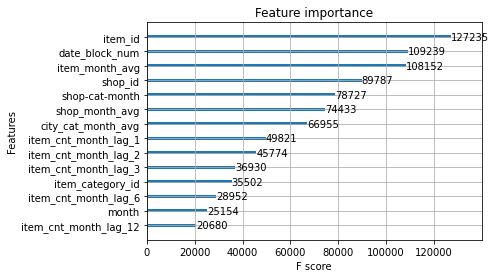

In [97]:
plot_importance(reg)
plt.show()

In the graph we can see that the most information is held in the item_id field. As was expected, the sales from the previous month are more relevent than other previous sales.
The fact that item_month_avg is ranked so high tells us there is a strong seasonality factor in sales.

In [96]:
train = sales.query('date_block_num < 34')
test = sales.query('date_block_num == 34')
X = train.drop(['item_cnt_month'], axis=1)
y = train['item_cnt_month']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
del X
del y

X_train.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'month', 'year',
       'item_category_id', 'city', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'shop_month_avg',
       'item_month_avg', 'city_cat_month_avg', 'shop-cat-month'],
      dtype=object)

# 3.c
Even though our dataframe holds up a lot of information we can use, let's see how a pure embedding-based ANN model will perform.

In [0]:
shop_inp = Input(shape=(1,),dtype='float64')
item_inp = Input(shape=(1,),dtype='float64')
item_cat_inp = Input(shape=(1,),dtype='float64')
city_inp = Input(shape=(1,),dtype='float64')
month_inp = Input(shape=(1,),dtype='float64')
year_inp = Input(shape=(1,),dtype='float64')

shop_emb = Embedding(len(sales['shop_id'].unique()), 8, input_length=1, embeddings_regularizer=l2(1e-6))(shop_inp)
item_emb = Embedding(len(sales['item_id'].unique()), 50, input_length=1, embeddings_regularizer=l2(1e-6))(item_inp)
item_cat_emb = Embedding(len(sales['item_category_id'].unique()), 9, input_length=1, embeddings_regularizer=l2(1e-6))(item_cat_inp)
city_emb = Embedding(len(sales['city'].unique()), 6, input_length=1, embeddings_regularizer=l2(1e-6))(city_inp)
month_emb = Embedding(len(sales['month'].unique()), 4, input_length=1, embeddings_regularizer=l2(1e-6))(month_inp)
year_emb = Embedding(len(sales['year'].unique()), 2, input_length=1, embeddings_regularizer=l2(1e-6))(year_inp)

In [113]:
x = concatenate([shop_emb, item_emb, item_cat_emb, city_emb, month_emb, year_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)
x = Dense(1, activation='relu')(x)

nn_model = Model([shop_inp, item_inp, item_cat_inp, city_inp, month_inp, year_inp], x)

nn_model.compile(loss=root_mean_squared_error ,optimizer='Adam')

nn_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_73 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1286580 samples, validate on 321645 samples
Epoch 1/15
  12288/1286580 [..............................] - ETA: 2:34 - loss: 3.1338

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1286580/1286580 [==============================] - 28s 22us/step - loss: 2.5732 - val_loss: 2.3773
Epoch 2/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.3991 - val_loss: 2.3192
Epoch 3/15
1286580/1286580 [==============================] - 27s 21us/step - loss: 2.3469 - val_loss: 2.2214
Epoch 4/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.3218 - val_loss: 2.1833
Epoch 5/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.2967 - val_loss: 2.1098
Epoch 6/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.2720 - val_loss: 2.0991
Epoch 7/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.2485 - val_loss: 2.0738
Epoch 8/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.2362 - val_loss: 2.0908
Epoch 9/15
1286580/1286580 [==============================] - 26s 20us/step - loss: 2.2212 - val_loss: 2.0436
Epoch 10/15
1286580/1

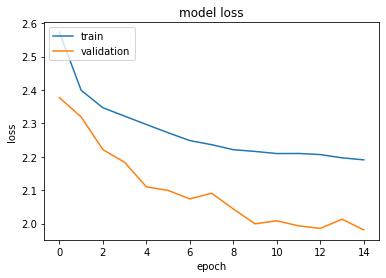

In [99]:
history = nn_model.fit([X_train['shop_id'], X_train['item_id'], X_train['item_category_id'], 
                        X_train['city'], X_train['month'], X_train['year']],y_train,epochs=15,
                 validation_data=[[X_val['shop_id'], X_val['item_id'], X_val['item_category_id'], 
                        X_val['city'], X_val['month'], X_val['year']],y_val],batch_size = 1024, callbacks=set_callbacks())
plot_history(history)

The XGBoost model was far superior. This is probably due to the fact it was using a lot more information that is available.

Embedding was created for the following: shop, item, item category, city, month and year.

In [0]:
X_test = [test['shop_id'], test['item_id'], test['item_category_id'], 
                        test['city'], test['month'], test['year']]
predictions=nn_model.predict(X_test)
preds = pd.DataFrame(predictions, columns=['item_cnt_month'])
preds.to_csv('submissionC.csv',index_label='ID')

# 3.d
Now let's put to use the extra information we have engineered.

In [0]:
shop_inp = Input(shape=(1,),dtype='int32')
item_inp = Input(shape=(1,),dtype='int32')
item_cat_inp = Input(shape=(1,),dtype='int32')
city_inp = Input(shape=(1,),dtype='int32')
month_inp = Input(shape=(1,),dtype='int32')
year_inp = Input(shape=(1,),dtype='int16')


lag1 = Input(shape=(1,), dtype='float32')
lag2 = Input(shape=(1,), dtype='float32')
lag3 = Input(shape=(1,), dtype='float32')
lag6 = Input(shape=(1,), dtype='float32')
lag12 = Input(shape=(1,), dtype='float32')

shop_month_avg = Input(shape=(1,), dtype='float32')
item_month_avg = Input(shape=(1,), dtype='float32')
city_cat_month_avg = Input(shape=(1,), dtype='float32')
shop_cat_month_avg = Input(shape=(1,), dtype='float32')


shop_emb = Embedding(len(sales['shop_id'].unique()), 8, input_length=1, embeddings_regularizer=l2(1e-6))(shop_inp)
item_emb = Embedding(len(sales['item_id'].unique()), 50, input_length=1, embeddings_regularizer=l2(1e-6))(item_inp)
item_cat_emb = Embedding(len(sales['item_category_id'].unique()), 9, input_length=1, embeddings_regularizer=l2(1e-6))(item_cat_inp)
city_emb = Embedding(len(sales['city'].unique()), 6, input_length=1, embeddings_regularizer=l2(1e-6))(city_inp)
month_emb = Embedding(len(sales['month'].unique()), 4, input_length=1, embeddings_regularizer=l2(1e-6))(month_inp)
year_emb = Embedding(len(sales['year'].unique()), 2, input_length=1, embeddings_regularizer=l2(1e-6))(year_inp)


shop_emb = Reshape((8,))(shop_emb)
item_emb = Reshape((50,))(item_emb)
item_cat_emb = Reshape((9,))(item_cat_emb)
city_emb = Reshape((6,))(city_emb)
month_emb = Reshape((4,))(month_emb)
year_emb = Reshape((2,))(year_emb)


In [17]:
x = concatenate([shop_emb, item_emb, item_cat_emb, city_emb, month_emb,
                 year_emb,
                 lag1, lag2, lag3, lag6, lag12, shop_month_avg,
                 item_month_avg, city_cat_month_avg, shop_cat_month_avg
                 ])


x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)

x = Dense(1, activation='relu')(x)

nn_model = Model([shop_inp, item_inp, item_cat_inp, city_inp, month_inp,
                  year_inp, lag1, lag2, lag3, lag6, lag12, shop_month_avg,
                  item_month_avg, city_cat_month_avg ,shop_cat_month_avg], x)

nn_model.compile(loss=root_mean_squared_error ,optimizer='Adam')

nn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1286580 samples, validate on 321645 samples
Epoch 1/30
1286580/1286580 [==============================] - 19s 15us/step - loss: 2.2802 - val_loss: 1.8965
Epoch 2/30
1286580/1286580 [==============================] - 17s 13us/step - loss: 2.0798 - val_loss: 1.9150
Epoch 3/30
1286580/1286580 [==============================] - 17s 13us/step - loss: 2.0543 - val_loss: 1.8492
Epoch 4/30
1286580/1286580 [==============================] - 17s 13us/step - loss: 2.0362 - val_loss: 1.9099
Epoch 5/30
1286580/1286580 [==============================] - 17s 13us/step - loss: 2.0326 - val_loss: 1.9205
Epoch 6/30
1286580/1286580 [==============================] - 17s 14us/step - loss: 2.0322 - val_loss: 1.9226
Epoch 7/30
1286580/1286580 [==============================] - 17s 13us/step - loss: 2.0213 - val_loss: 1.9139
Epoch 8/30
1286580/1286580 [==============================] - 17s 13us/step - loss: 2.0173 - val_loss: 1.9023
Epoch 9/30
1286580/1286580 [==============================] - 17s 1

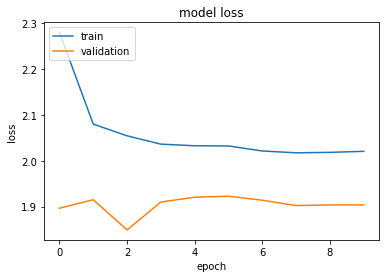

In [18]:
features = ['shop_id', 'item_id', 'item_category_id', 'city', 'month', 'year',
            'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
            'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'shop_month_avg',
            'item_month_avg', 'city_cat_month_avg', 'shop-cat-month']

history = nn_model.fit([X_train[feature] for feature in features],y_train,epochs=30,
                 validation_data=[[X_val[feature] for feature in features], y_val],
                 batch_size = 1024, callbacks=set_callbacks())
plot_history(history)

We can see this model performs much better than the previous one, but still not as good as XGBoost. 

While we wanted to employ an LSTM layer as well, we weren't able to in the given time frame. This is a possible future work.

In [0]:
X_test = [test[feature] for feature in features]
predictions=nn_model.predict(X_test)
preds = pd.DataFrame(predictions, columns=['item_cnt_month'])
preds.to_csv('submissionE.csv',index_label='ID')

# 3.f - insights regarding embedding

Classically, dealing with categorical features has two solutions:
1. one-hot encondig. On this data set, encoding the item_id feature, which has thousands of unique categories, would have resulted in a very memory-hungry representation.
2. Label encoding, which we employed for the vanilla XGBoost model.

Category embedding can be viewed as a compromise between the two. It encodes the category in an embedding space smaller than one-hot, and larger than label encoding. This enables the NN to capture semantic resemblances between different categories. For example, if there are public holidays during May and September which affect sales, the represntation 5 for May, and 9 for september would not show this relationship. An embedding will result in two relatively similar vector representation for those months.



# 3.g

Let's use the embedding layers as features for an XGBoost model, and see if we can improve our firdt model's performance

In [152]:
nn_model.layers.pop()
reg = xgb.XGBRegressor(n_estimators=200, max_depth=15, objective='reg:squarederror')
reg.fit(nn_model.predict([X_train[feature] for feature in features]),y_train,
        eval_set=[(nn_model.predict([X_train[feature] for feature in features]),y_train),
                  (nn_model.predict([X_val[feature] for feature in features]), y_val)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:2.7371	validation_1-rmse:2.75977
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.50811	validation_1-rmse:2.54341
[2]	validation_0-rmse:2.30587	validation_1-rmse:2.35428
[3]	validation_0-rmse:2.12784	validation_1-rmse:2.18983
[4]	validation_0-rmse:1.97165	validation_1-rmse:2.04763
[5]	validation_0-rmse:1.83522	validation_1-rmse:1.92535
[6]	validation_0-rmse:1.7164	validation_1-rmse:1.82102
[7]	validation_0-rmse:1.61346	validation_1-rmse:1.73241
[8]	validation_0-rmse:1.52474	validation_1-rmse:1.65752
[9]	validation_0-rmse:1.44859	validation_1-rmse:1.5949
[10]	validation_0-rmse:1.3836	validation_1-rmse:1.54267
[11]	validation_0-rmse:1.3282	validation_1-rmse:1.49943
[12]	validation_0-rmse:1.28132	validation_1-rmse:1.46375
[13]	validation_0-rmse:1.24184	validation_1-rmse:1.43451
[14]	validation_0-rmse:1.20852	validation_1-rmse:1.41069
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

The current model's performance is better the one we got from the ANN model. This time we even imporved a bit the original XGBoost model.

Next, we will try using the concatenation layer's output. Perhaps XGBoost will be able to use the abundance of information in that layer better than our ANN.

The concatenation layer holds the raw data from the numerical features as well as the embeddings for categorical features.

In [21]:
layer_name = 'concatenate_1'
intermediate_layer_model = Model(inputs=nn_model.input,
                                       outputs=nn_model.get_layer(layer_name).output)

reg = xgb.XGBRegressor(n_estimators=200, max_depth=5, objective='reg:squarederror')
reg.fit(intermediate_layer_model.predict([X_train[feature] for feature in features]),y_train,
        eval_set=[(intermediate_layer_model.predict([X_train[feature] for feature in features]),y_train),
                  (intermediate_layer_model.predict([X_val[feature] for feature in features]), y_val)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:2.79369	validation_1-rmse:2.79686
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.6165	validation_1-rmse:2.61949
[2]	validation_0-rmse:2.45878	validation_1-rmse:2.46234
[3]	validation_0-rmse:2.32298	validation_1-rmse:2.32702
[4]	validation_0-rmse:2.20316	validation_1-rmse:2.20741
[5]	validation_0-rmse:2.09993	validation_1-rmse:2.10478
[6]	validation_0-rmse:2.01218	validation_1-rmse:2.0176
[7]	validation_0-rmse:1.93237	validation_1-rmse:1.93826
[8]	validation_0-rmse:1.86495	validation_1-rmse:1.87156
[9]	validation_0-rmse:1.80663	validation_1-rmse:1.81395
[10]	validation_0-rmse:1.75862	validation_1-rmse:1.76653
[11]	validation_0-rmse:1.71284	validation_1-rmse:1.7213
[12]	validation_0-rmse:1.67642	validation_1-rmse:1.68578
[13]	validation_0-rmse:1.64437	validation_1-rmse:1.65451
[14]	validation_0-rmse:1.61566	validation_1-rmse:1.62652

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

As we can see, this model did not improve performance, and actually takes up a lot more memory and a long time to train and predict, due the vast number of inputs.